In [1]:
import os
import sys

try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(current_dir, ".."))  
if project_root not in sys.path:
    sys.path.append(project_root)

In [3]:
# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import math
import numpy as np
import pandas as pd
import random
import scipy.sparse as sp
from utils_elicitation import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df, threshold_interactions_df_plus, train_test_split_csr

# !pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

# %matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic_pair import Heuristic5
from pct.tree.heuristic.NumericHeuristic_pair import NumericHeuristic5
from pct.tree.splitter.splitter_yahoo import Splitter
from pct.tree.Yahootree import Tree

In [9]:
filtered_df = pd.read_csv("filtered_semi_binary.csv")
filtered_df

,user_id,item_id,rating,item_type,artist_id,genre_ids
0,9,238709,0.00,artist,238709,0
1,9,169510,0.00,artist,169510,0
2,9,208084,1.00,artist,208084,0
3,9,245398,0.00,artist,245398,0
4,9,153166,0.00,artist,153166,0
...,...,...,...,...,...,...
1524889,248947,83754,0.01,artist,83754,0
1524890,248947,141799,0.00,genre,0,[141799]
1524891,248947,141677,0.00,artist,141677,0
1524892,248947,262458,0.00,artist,262458,0


In [11]:
# item type map
item_type_map = filtered_df.drop_duplicates(subset='item_id')[['item_id', 'item_type']]
item_type_map = dict(zip(item_type_map['item_id'], item_type_map['item_type']))

In [13]:
def get_item_type(item_id):
    return item_type_map.get(item_id, 'unknown')  


In [19]:
all_user_ids = sorted(filtered_df['user_id'].unique().tolist())

def split_users_by_ratio(all_user_ids, ratio):
    n = len(all_user_ids)
    split_point = int(n * ratio)
    warm_users = all_user_ids[:split_point]
    cold_users = all_user_ids[split_point:]
    return warm_users, cold_users

In [25]:
def split_and_combine(strategy="artist-only"):
    """Handles both approaches with proper matrix alignment"""
    # Get full cold matrix and mappings
    matrix_cold, rid_to_idx_cold, _, cid_to_idx, _ = df_to_matrix(
        df_cold, "user_id", "item_id", "rating"
    )
    matrix_cold = matrix_cold.tocsr()

    # Create boolean masks
    artist_mask = np.isin(
        np.arange(matrix_cold.shape[1]), 
        [cid_to_idx[iid] for iid in df_cold[df_cold['item_type'] == 'artist']['item_id']]
    )
    genre_mask = ~artist_mask

    # Create aligned matrices
    matrix_cold_artist = matrix_cold.multiply(artist_mask)
    matrix_cold_genre = matrix_cold.multiply(genre_mask)
    matrix_cold_artist = matrix_cold.multiply(artist_mask).tocsr()
    matrix_cold_genre = matrix_cold.multiply(genre_mask).tocsr()

    al_artist, test_cold, _ = train_test_split(
        matrix_cold_artist, 
        split_count=30,
        fraction=None
    )
    
    if strategy == "artist-only":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)  
        return K_cold, X_cold, test_cold
    
    elif strategy == "hybrid":
        X_cold, K_cold, _ = train_test_split_csr(al_artist, 1)
        X_cold = X_cold + matrix_cold_genre
        return K_cold, X_cold, test_cold

In [43]:
def data_builder(seed, warm_ratio=0.1, strategy="artist-only"):
    """
    说明：
    - fixed horiztonal split_users_by_ratio：warm/cold ）
    - randomness from K/X/T 的 np.random.choice（ np.random.seed(seed)）

    return：
    dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )
    """
    import random
    import numpy as np

    # 1) Python random and NumPy random
    random.seed(seed)
    np.random.seed(seed)

    # 2) warm/cold split
    all_user_ids = sorted(filtered_df['user_id'].unique().tolist())
    warm_users_idx, cold_users_idx = split_users_by_ratio(all_user_ids, warm_ratio)

    # 3) global warm and cold dataframe
    global df_warm, df_cold
    df_warm = filtered_df[filtered_df['user_id'].isin(warm_users_idx)].copy()
    df_cold = filtered_df[filtered_df['user_id'].isin(cold_users_idx)].copy()

    # 4) matrix and mapping
    matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
        df_warm, "user_id", "item_id", "rating"
    )
    matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix( 
    df_cold, "user_id", "item_id", "rating")

    # 5) K/X/T split (randomness)
    K_cold, X_cold, T_cold = split_and_combine(strategy)

    # 6) return
    return dict(
        train=K_cold, test=T_cold, X=X_cold, matrix_warm=matrix_warm,
        idx_to_rid_cold=idx_to_rid_cold, idx_to_rid_warm=idx_to_rid_warm, idx_to_cid=idx_to_cid,
        warm_users=warm_users_idx, cold_users=cold_users_idx
    )


In [45]:
# 1) two different seeds
out1 = data_builder(seed=7,  strategy="artist-only")
out2 = data_builder(seed=11, strategy="artist-only")

# 2) check warm/cold consistency（fixed aplit）
assert out1["warm_users"] == out2["warm_users"], "Warm split changed unexpectedly!"
assert out1["cold_users"] == out2["cold_users"], "Cold split changed unexpectedly!"

# 3) check if X / K / T change with seed set
#   check differnce in sparsity matrix
diff_X_nnz = (out1["X"] - out2["X"]).nnz
diff_K_nnz = (out1["train"] - out2["train"]).nnz
diff_T_nnz = (out1["test"] - out2["test"]).nnz
print("Δnnz(X)=", diff_X_nnz, "Δnnz(K)=", diff_K_nnz, "Δnnz(T)=", diff_T_nnz)

# 4) difference >0
assert (diff_X_nnz + diff_T_nnz) > 0, "K/X/T did not change across seeds as expected."


Δnnz(X)= 39948 Δnnz(K)= 1357 Δnnz(T)= 38739


In [46]:
def elicitation_by_pairwise_tree_retrain_skiped(
    Tree, train, test, X, matrix_warm,
    idx_to_rid_cold, idx_to_rid_warm, idx_to_cid,
    iteration=5, strategy=1,
    svd_random_state=None  # ← new parmeter：SVD random seed set
):
    """
    Pairwise tree-based elicitation (skip asked pairs). Retrain tree each round.
    At each iteration, select first unasked (itemA, itemB) pair and move both ratings from X to K.

    Parameters:
    - strategy: 1 (top2), 2 (most similar), 3 (least similar)

    Returns:
    - rmse_list, mae_list: performance metrics per iteration
    - item_type_stats: per-round asked item type counts
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    asked_pairs = {u: set() for u in range(num_users)}
    item_type_stats = defaultdict(lambda: defaultdict(int))
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(0, 1))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    # --- new：initialize SVD by random seed---
    algo = SVD(random_state=svd_random_state)
    # -------------------------------------------------
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    # Iterative elicitation
    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked pairs, walk from root)")
        # Step 1: Retrain tree
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        coldK_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, coldK_df], ignore_index=False)

        pct = Tree(max_depth=i+1, min_instances=5, item_type_map=item_type_map)
        pct.fit(x_df, x_df, strategy=strategy)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = pct.root
            while node and not node.is_leaf and node.attribute_name:
                itemA, itemB = node.attribute_name
                if itemA not in cid_to_idx or itemB not in cid_to_idx:
                    node = None
                    break

                itemA_idx = cid_to_idx[itemA]
                itemB_idx = cid_to_idx[itemB]
                pair = frozenset([itemA_idx, itemB_idx])

                if pair in asked_pairs[u]:
                    ratingA = train_copy[u, itemA_idx]
                    ratingB = train_copy[u, itemB_idx]
                    if ratingA > ratingB:
                        node = node.children[0]
                    elif ratingB > ratingA:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked pair found
                ratingA = X_copy[u, itemA_idx]
                ratingB = X_copy[u, itemB_idx]

                if ratingA > 0:
                    train_copy[u, itemA_idx] = ratingA
                    X_copy[u, itemA_idx] = 0
                if ratingB > 0:
                    train_copy[u, itemB_idx] = ratingB
                    X_copy[u, itemB_idx] = 0

                asked_pairs[u].add(pair)

                # 🌟 Record item type (based on itemA)
                item_type = get_item_type(itemA)
                item_type_stats[i][item_type] += 1

                break  # only one pair per user per iteration

        # Step 2: Evaluate
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        # --- new：evauate SVD by same random seed---
        algo = SVD(random_state=svd_random_state)
        # -------------------------------------------------------------
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list, item_type_stats


In [47]:

def run_many_times_single_strategy(
    Tree,
    seeds,                 # e.g., [101,102,103,104,105]  -> R=5
    iteration=2,           # per time run iterations（keep baseline -> max curve lenghth=iteration+1）
    strategy=2,            # 1=top2, 2=most-similar, 3=least-similar
    mode="hybrid"          # hybrid
):
    """
    return:
      curves: np.ndarray, shape=(R, iteration+1)
              eveay row is a curve，including baseline
    """
    curves = []
    for sd in seeds:
        # 1) construct run data this iteration（K/X/T controled by seed）
        data = data_builder(seed=sd, strategy=mode)
        # 2)  elicitation（SVD by seed）
        rmse_list, _, _ = elicitation_by_pairwise_tree_retrain_skiped(
            Tree,
            data["train"], data["test"], data["X"], data["matrix_warm"],
            data["idx_to_rid_cold"], data["idx_to_rid_warm"], data["idx_to_cid"],
            iteration=iteration, strategy=strategy,
            svd_random_state=sd
        )
        curves.append(rmse_list)  # 长度 = iteration+1
    return np.stack(curves, axis=0)  # (R, iteration+1)


# —— average + min–max interval ——
def plot_mean_with_range_single(
    curves,                 # (R, T+1)，含 baseline
    title="Pairwise (single strategy)",
    label="Strategy"
):
    R, L = curves.shape
    T = L - 1  # iterations
    x = np.arange(0, L)  # from 0 baseline

    mean_curve = curves.mean(axis=0)
    lo = curves.min(axis=0)
    hi = curves.max(axis=0)

    plt.figure(figsize=(7,5))
    plt.plot(x, mean_curve, label=f"{label} (mean)")
    plt.fill_between(x, lo, hi, alpha=0.2, label="min–max range")
    plt.xticks(x, [f"{i}" for i in x])  # show 0,1,...,T；0 is baseline
    plt.xlabel("Iteration (0 = baseline)")
    plt.ylabel("RMSE")
    plt.title(f"{title} (R={R}) — Mean with min–max bands")
    plt.legend()
    plt.tight_layout()
    plt.show()


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 278591
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5639
MAE:  0.4115
✅ Iteration 1 complete.

🔁 Iteration 2/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 278591
🔍 Pair found: 189272, 132285
🔍 Pair found: 195412, 151565
🔍 Pair found: 83754, 278591
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5529
MAE:  0.4117
✅ Iteration 2 complete.
🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 278591
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration.

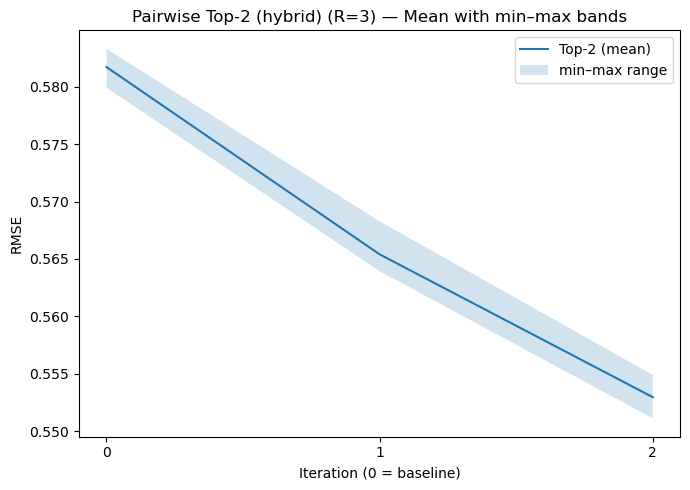

In [35]:
seeds = [101,102,103]  # R=5
T = 2                          # run iterations per time


curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
# curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
# curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
# plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
# plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 214565
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5453
MAE:  0.4103
✅ Iteration 1 complete.

🔁 Iteration 2/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 214565
🔍 Pair found: 178617, 166141
🔍 Pair found: 191898, 247758
🔍 Pair found: 278591, 85921
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5327
MAE:  0.4126
✅ Iteration 2 complete.
🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 214565
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration.

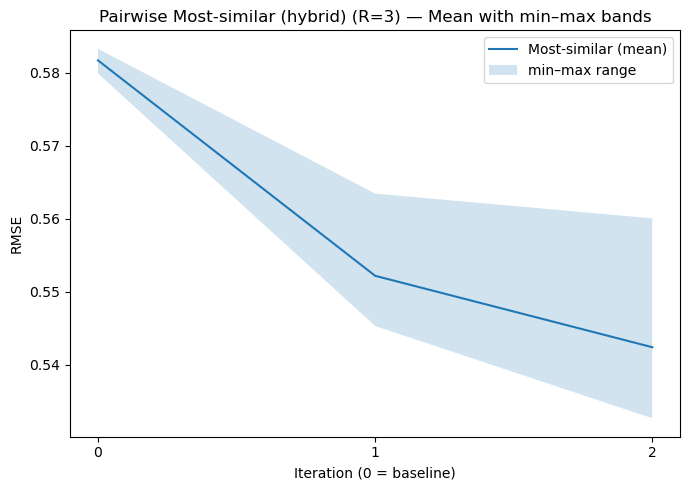

In [36]:
seeds = [101,102,103]  # R=5
T = 2                           # run iterations per time


# curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
# curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


#plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
# plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")


🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5819
MAE:  0.4107
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 47482
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5658
MAE:  0.4126
✅ Iteration 1 complete.

🔁 Iteration 2/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 830
🔍 Pair found: 144802, 47482
🔍 Pair found: 214565, 119167
🔍 Pair found: 278591, 167365
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 0.5625
MAE:  0.4115
✅ Iteration 2 complete.
🔍 Evaluating baseline RMSE/MAE...
RMSE: 0.5833
MAE:  0.4100
✅ Baseline evaluation complete.

🔁 Iteration 1/2 (skip asked pairs, walk from root)
✅Initializing Splitter...
✅ Calling build()...
🔍 Pair found: 172223, 47482
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RM

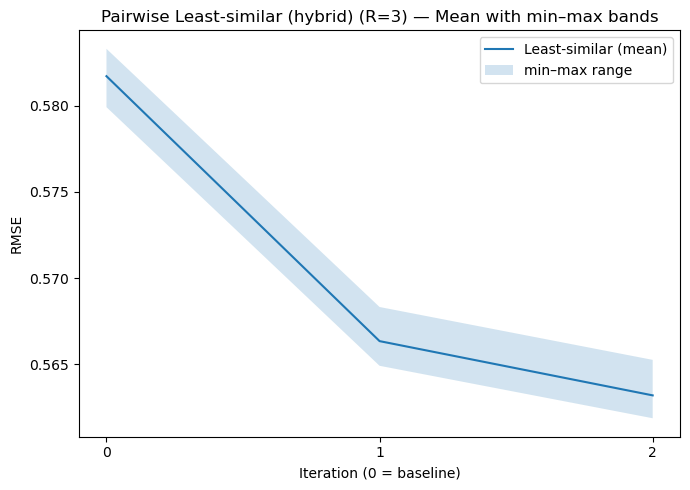

In [37]:
seeds = [101,102,103]  # R=5
T = 2                           # run iterations per time


#curves_s1 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=1, mode="hybrid")
# curves_s2 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=2, mode="hybrid")
curves_s3 = run_many_times_single_strategy(Tree, seeds, iteration=T, strategy=3, mode="hybrid")


# plot_mean_with_range_single(curves_s1, title="Pairwise Top-2 (hybrid)", label="Top-2")
# plot_mean_with_range_single(curves_s2, title="Pairwise Most-similar (hybrid)", label="Most-similar")
plot_mean_with_range_single(curves_s3, title="Pairwise Least-similar (hybrid)", label="Least-similar")
